### 🏥 Hospital Reviews Dataset

This notebook performs data cleaning and exploratory analysis on a dataset of patient reviews from a hospital system.

The goal is to clean the text and explore patterns in positive and negative feedback using NLP techniques.

**Columns:**
- `Feedback`: patient comments (free text)
- `Sentiment label`: 1, 0
- `Ratings`: numerical rating given by patient

#### 1. Import Libraries

In [189]:
# Libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\luisi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### 2. Dataset overview

Let's start by exploring the dataset structure. We'll check the number of rows and columns, as well as the data types and any missing values. This helps ensure that the data is usable before applying cleaning or transformations.

In [192]:
df = pd.read_csv(r"C:\Users\luisi\Documents\Projects\hospital-reviews\data\dataset_hospital_reviews.csv")

# Quick overview
df.head()
df.info()

# Preview some sample reviews
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996 entries, 0 to 995
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback         996 non-null    object 
 1   Sentiment Label  996 non-null    int64  
 2   Ratings          996 non-null    int64  
 3   Unnamed: 3       0 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 31.3+ KB


,Feedback,Sentiment Label,Ratings,Unnamed: 3
0,Good and clean hospital. There is great team o...,1,5,NaN
1,Had a really bad experience during discharge. ...,1,5,NaN
2,I have visited to take my second dose and Proc...,1,4,NaN
3,That person was slightly clueless and offered...,1,3,NaN
4,There is great team of doctors and good OT fac...,0,1,NaN


#### 3. Dataset cleaning

In [195]:
# Drop the empty/unnecessary column
df = df.drop(columns=["Unnamed: 3"])

df.isna().sum()

Feedback           0
Sentiment Label    0
Ratings            0
dtype: int64

  
To ensure consistency and avoid issues when referencing columns, we convert all column names to lowercase and replace spaces with underscores:

In [198]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

list(df.columns)

['feedback', 'sentiment_label', 'ratings']

In [200]:
# Check random examples from each sentiment class
print("Sentiment = 0 (possibly negative):")
display(df[df['sentiment_label'] == 0]['feedback'].sample(3).values)

print("\nSentiment = 1 (possibly positive):")
display(df[df['sentiment_label'] == 1]['feedback'].sample(3).values)

Sentiment = 0 (possibly negative):


array(['The staff is not at all helpful and do not give clear instructions',
       'Poorly managed patient flow.',
       'Matter is not specifically the money it is the attitude or gesture which hurts the tensed patients.'],
      dtype=object)


Sentiment = 1 (possibly positive):


array(['Gynecologist Bhavani madam is good treating communication and treatment all is v good',
       'He was very patient and was of great help for us throughout the admin process',
       'Experienced doctors and Management staff  Clean and systematic hospital.'],
      dtype=object)

##### Understanding the Sentiment Labels

To verify what each value in the `sentiment_label` colum represents, we sampled a few reviews for each class:

- **Label `1`** clearly corresponds to positive reviews, often praising the service or staff.
- **Label `0`** corresponds to negative feedback, including complaints or dissatisfaction.

We'll use this binary label as the target for sentiment classification.

In [203]:
# Map sentiment label to descriptive text
sentiment_map = {
    0: 'Negative',
    1: 'Positive'
}

df['sentiment_desc'] = df['sentiment_label'].map(sentiment_map)

We clean the patient reviews by removing punctuation, stopwords, numbers, and URLs, converting everything to lowercase, and applying lemmatization. This prepares the text for further analysis and modeling:

In [206]:
# cleaning function: "Feedback"
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return " ".join(tokens)

In [208]:
# Apply cleaning function to 'Feedback' column
df['clean_text'] = df['feedback'].apply(clean_text)

In [209]:
# Compare original vs cleaned text
df[['feedback', 'clean_text']].sample(5)

,feedback,clean_text
72,Very good hospital and care.Excellent services...,good hospital careexcellent service happy fortis
308,Dr Sapna Lulla was very nice everything was ve...,dr sapna lulla nice everything smooth
634,The staff seem to have become less responsive ...,staff seem become le responsive lax covid prob...
961,the experience was very hassle free as everyth...,experience hassle free everything well managed...
578,Very good consultation with dr Karthik sir Ge...,good consultation dr karthik sir general medic...


#### 4. EDA

#### 4.1 Sentiment distribution

We visualize the distribution of positive and negative reviews to understand class balance. This is important for evaluating classification performance later on.

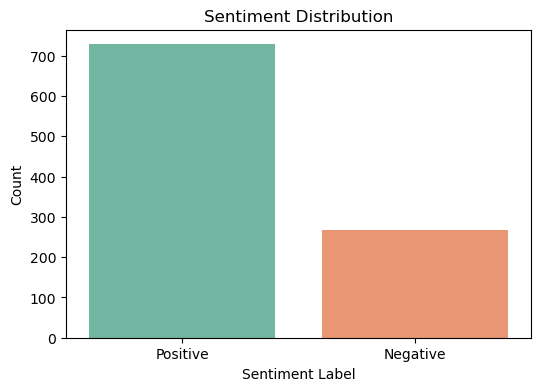

In [214]:
# Plot sentiment label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment_desc', hue='sentiment_desc', data=df, palette='Set2', legend=False)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.show()

#### 4.2 Lenght of reviews in number of words

We identify the most common words across all cleaned reviews. This gives insight into what patients talk about most often, regardless of sentiment.

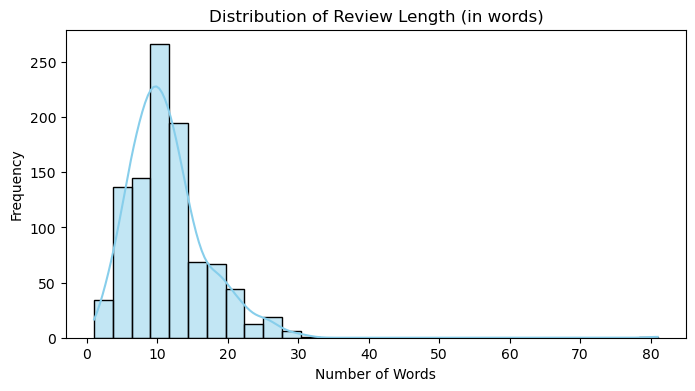

In [217]:
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(8, 4))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Review Length (in words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

##### Review Length Analysis:

Before diving deeper into word-level analysis, it's useful to understand the general size of the reviews.

We calculated the number of words in each cleaned review and plotted the distribution. This helps us:

- Detect potential outliers (very short or very long reviews)
- Understand how detailed the feedback tends to be
- Prepare for decisions in text preprocessing (e.g. truncation in modeling)

Most patient reviews are between **5 and 20 words** long, with the majority centered around **10–12 words**.
This suggests that the reviews are generally short and concise.

#### 4.3 Top 15 Most Frequent Words

This bar chart shows the most common words used across all patient reviews after cleaning and preprocessing. It helps identify the dominant topics or recurring terms in the overall feedback.

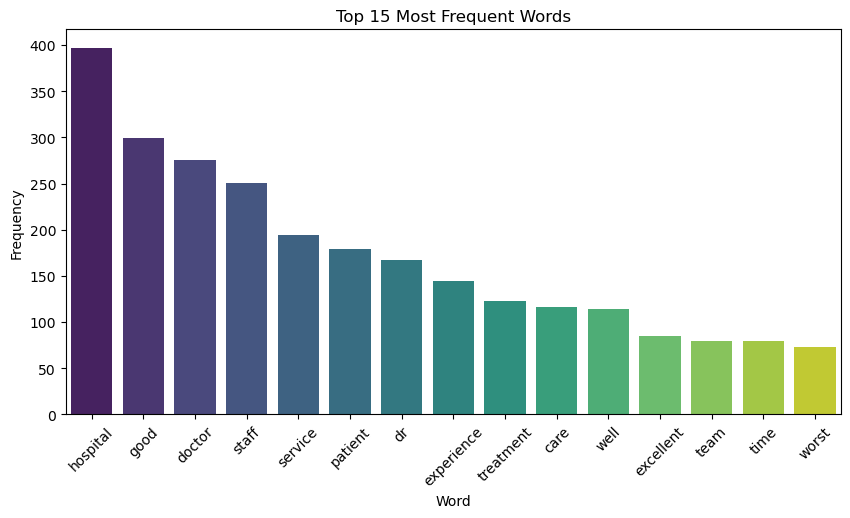

In [223]:
# Get most common words from all cleaned text
all_words = " ".join(df['clean_text']).split()
word_freq = Counter(all_words).most_common(15)

# Convert to DataFrame
freq_df = pd.DataFrame(word_freq, columns=['word', 'count'])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=freq_df, x='word', y='count', palette='viridis', hue='word', legend=False)
plt.title("Top 15 Most Frequent Words")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

##### Observation frequent words:

The chart above displays the 15 most frequently used words across all patient reviews. 

We can see that terms like **"hospital"**, **"doctor"**, **"staff"**, and **"service"** dominate the feedback. Most of them reflect neutral or positive sentiment, but the presence of words like **"worst"** and **"time"** may indicate issues or frustration in some cases.

This supports what we saw in the word clouds and helps confirm common topics in patient experiences.

#### 4.4 Word Cloud

We create word clouds for both positive and negative reviews. This highlights the vocabulary typically associated with each sentiment class and helps us spot recurring themes in patient feedback.

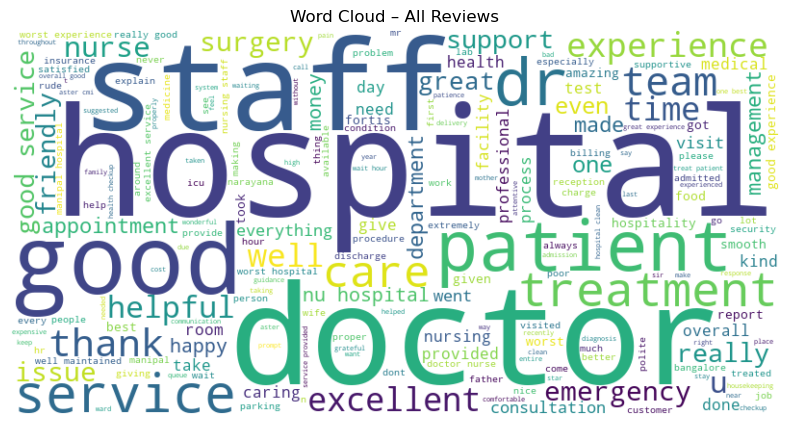

In [125]:
# All reviews

# Join all cleaned text
all_text = " ".join(df['clean_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – All Reviews")
plt.show()

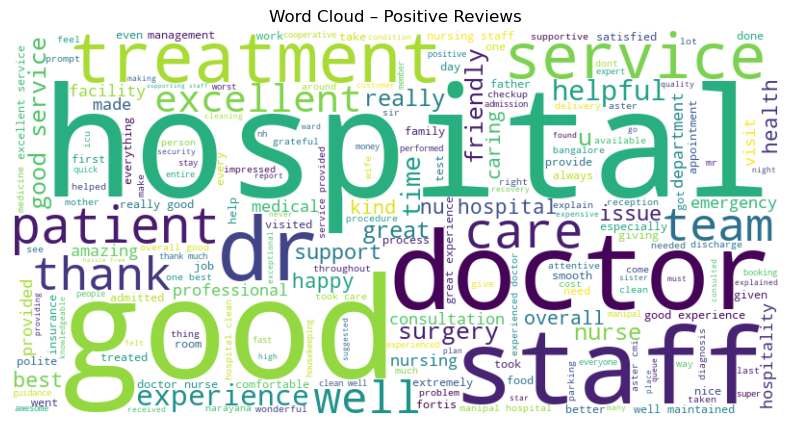

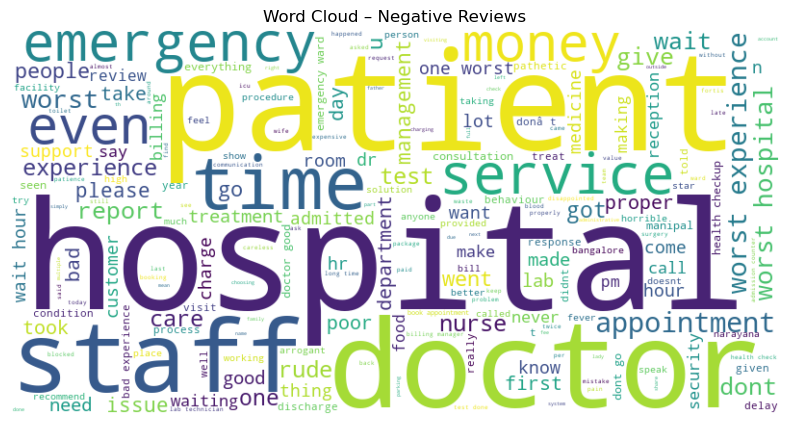

In [127]:
# reviews for each sentiment
positive_text = " ".join(df[df['sentiment_desc'] == "Positive"]['clean_text'])
negative_text = " ".join(df[df['sentiment_desc'] == "Negative"]['clean_text'])

# Word cloud – Positive
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Positive Reviews")
plt.show()

# Word cloud – Negative
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud – Negative Reviews")
plt.show()

#### 5. Save Cleaned Dataset

We export the cleaned dataset so it can be used in the next steps, including feature engineering and model training.

In [236]:
df.to_csv(r"C:\Users\luisi\Documents\Projects\hospital-reviews\data\dataset_hospital_reviews_cleaned.csv", index=False)

### EDA Summary:

Through this exploratory analysis, we gained a better understanding of the patient feedback data:

- The dataset is relatively balanced, with slightly more positive reviews than negative.
- Most reviews are short, typically between 5 and 20 words.
- Positive reviews frequently mention staff, cleanliness, and satisfaction.
- Negative reviews tend to mention issues related to waiting times, emergency services, or problems during the visit.
- The most frequent words overall reflect common healthcare themes, but also reveal potential dissatisfaction through terms like "worst" and "time".

These insights confirm that sentiment is reflected in the language used by patients. We are now ready to move forward and build a sentiment classification model using this cleaned and analyzed data.